## Training a DDPMS 

I followed this notebook:
https://colab.research.google.com/drive/14Pez9Bs21I6Phw27Byu0jLk23_YFKqNb#scrollTo=1f740dfe-e610-4479-ac30-cce1f9e62553

### Prepare the dataset

In [1]:
from datasets import load_dataset
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os

# To track the losses 
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter(log_dir=config.output_dir + "/runs/test")

/home/dalia/Documents/pilot-face-generator/envs/face-gen_vp310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 3
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-faces-128'  # the model namy locally and on the HF Hub

    push_to_hub = False #True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [3]:
config.num_epochs = 1
run_name = "test5"

#writer = SummaryWriter(os.path.join(config.output_dir, os.path.join("tensorboard", run_name)))


In [4]:
# Getting the dataset from HF

config.dataset_name = "HuggingFaceM4/FairFace"

big_train_dataset = load_dataset(config.dataset_name, "0.25", split="train")
big_valid_dataset = load_dataset(config.dataset_name, "0.25", split="validation")

# Or just load images from a local folder!
# config.dataset_name = "imagefolder"
# dataset = load_dataset(config.dataset_name, data_dir="path/to/folder")

In [5]:
type(big_train_dataset)

datasets.arrow_dataset.Dataset

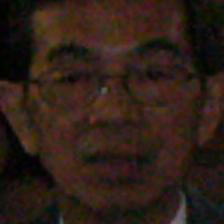

In [6]:
big_train_dataset[0]["image"]

##### Making a small dataset for testing

In [11]:
small_ds = big_valid_dataset.train_test_split(test_size=0.2,seed=123,stratify_by_column="race",)
#small_ds = small_ds["train"].train_test_split(test_size=0.2,seed=123,stratify_by_column="race",)

train_dataset = small_ds["train"]
valid_dataset = small_ds["test"]

print(f"The small training dataset has {train_dataset.shape[0]} instances.")
print(f"The small validation dataset has {valid_dataset.shape[0]} instances.")

The small training dataset has 8763 instances.
The small validation dataset has 2191 instances.


In [15]:
# Let's just see examples of the data
#fig, axs = plt.subplots(1, 4, figsize=(16, 4))
#for i, image in enumerate(train_dataset[:4]["image"]):
#    axs[i].imshow(image)
#    axs[i].set_axis_off()
#fig.show()

### Processing data to fit in the model requirements

Note: It may be a good idea to implement something to improve the quality of the images

In [8]:
from torchvision import transforms
from torchvision.utils import make_grid
import torch


In [17]:
int(config.image_size*1.1)

140

In [ ]:
"""
preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
"""
preprocess = transforms.Compose(
    [
        #transforms.Resize((config.image_size, config.image_size)),
        transforms.Resize((int(config.image_size*1.1),int(config.image_size*1.1))),
        transforms.RandomCrop(config.image_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
) 
#"""



In [20]:
# Transform the shape of the data
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

train_dataset.set_transform(transform)
valid_dataset.set_transform(transform)

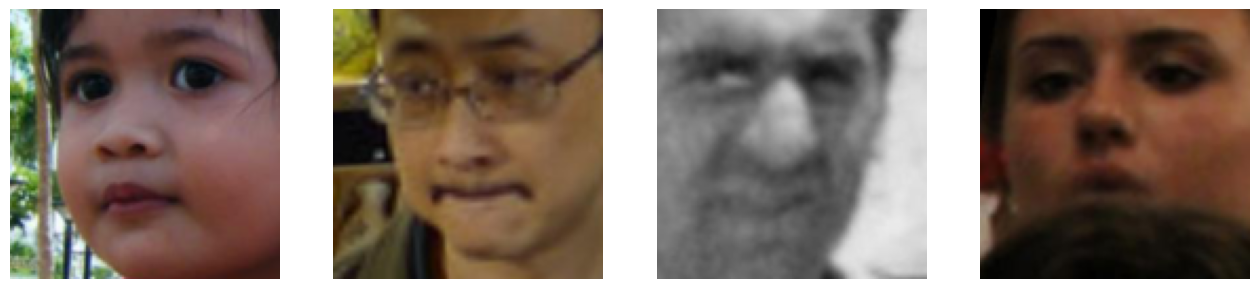

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(train_dataset[:4]["images"]):
    axs[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axs[i].set_axis_off()
fig.show()

In [14]:
# Now that all our images have the same size and are converted to tensors, we can create the dataloader we will use for training.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.eval_batch_size, shuffle=False)


In [15]:
# Push sample images to tensorboard
example = next(iter(val_dataloader))
img_grid = make_grid(example["images"])
#writer.add_image("Sample images", img_grid)
#writer.close()


### Define the difussion model

In [16]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
)

In [17]:
# Sample pass trough the model just to see dimensions
sample_image = train_dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


### Define noisy scheduler

In [18]:
from diffusers import DDPMScheduler # For the noise scheduler
import torch.nn.functional as F # To compute the loss

from PIL import Image

In [19]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

##### Example

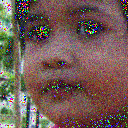

In [20]:
# Image sample when adding noise

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [21]:
# Sample loss for the example above
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [22]:
loss

tensor(1.2042, grad_fn=<MseLossBackward0>)

### Set up training

In [22]:
from diffusers.optimization import get_cosine_schedule_with_warmup # for the learning rate

from diffusers import DDPMPipeline
import os
import math
import json

# For training
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder

from tqdm.auto import tqdm
from pathlib import Path



In [24]:
def my_make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = my_make_grid(images, rows=4, cols=4)

    # Save the images    
    test_dir = os.path.join(config.output_dir, os.path.join("samples", run_name))
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs))

In [25]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, val_dataloader, run_name):
    # Initialize accelerator and tensorboard logging
    #writer = SummaryWriter(os.path.join(config.output_dir, os.path.join("tensorboard", run_name)))
    
    logging_dir = os.path.join(config.output_dir, os.path.join("logs", run_name))
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers(run_name)

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler, val_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler, val_dataloader
    )

    global_step = 0
    train_losses_per_epoch = []
    eval_losses_per_epoch = []

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        # ------ Training section
        
        epoch_train_loss = 0.0 # To save the loss per epoch
        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                epoch_train_loss += loss.item() # Store the running loss
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            #global_step += 1

            # Inside training step
            if global_step % 100 == 0:
                writer.add_scalar("Loss/train_step", loss.item(), global_step)

            global_step += 1

        # Save the train loss in this epoch
        avg_train_loss = epoch_train_loss / len(train_dataloader)
        train_losses_per_epoch.append(avg_train_loss)

        
        # ------ Evaluation section
        
        model.eval()
        epoch_eval_loss = 0.0
        num_eval_batches = 0

        for step, batch in enumerate(val_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)#.to(accelerator.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            with torch.no_grad():
                noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                epoch_eval_loss += loss.item()
                num_eval_batches += 1
        
        # Save the evaluation loss in this epoch
        avg_eval_loss = epoch_eval_loss / num_eval_batches
        eval_losses_per_epoch.append(avg_eval_loss)

        # Come back to training
        model.train()

        # Print progress bar
        print(f"Epoch {epoch}: Avg train Loss = {avg_train_loss:.4f}, Avg eval Loss = {avg_eval_loss:.4f}")

        # Load info to tensorboard
        #writer.add_scalar("Loss/train", avg_train_loss, epoch)
        #writer.add_scalar("Loss/eval", avg_eval_loss, epoch)
        writer.add_scalars("Losses per epoch", { "train": avg_train_loss, "eval": avg_eval_loss}, epoch)


        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=os.path.join(config.output_dir, run_name),
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(os.path.join(config.output_dir,run_name))
                    
            #print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Eval Loss = {avg_eval_loss:.4f}")
            #accelerator.log({"train_loss_epoch": avg_train_loss, "eval_loss_epoch": avg_eval_loss}, step=global_step)

        #model.train()

    writer.close()

    # To store the losses
    losses_folder = os.path.join(config.output_dir, os.path.join("losses", run_name))
    os.makedirs(losses_folder, exist_ok=True)
    with open(os.path.join(losses_folder,"train_losses.json"), "w") as f:
        json.dump(train_losses_per_epoch, f)
    with open(os.path.join(losses_folder,"eval_losses.json"), "w") as f:
        json.dump(eval_losses_per_epoch, f)


In [26]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, val_dataloader, run_name)

notebook_launcher(train_loop, args, num_processes=2)

Launching training on 2 GPUs.


Epoch 0:   0%|                                                                    | 0/274 [00:00<?, ?it/s]/home/dalia/Documents/pilot-face-generator/envs/face-gen_v3/lib/python3.11/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/dalia/Documents/pilot-face-generator/envs/face-gen_v3/lib/python3.11/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.

Epoch 0: Avg train Loss = 0.1807, Avg eval Loss = 0.0264
Epoch 0: Avg train Loss = 0.1780, Avg eval Loss = 0.0266



100%|██████████████████████████████| 1000/1000 [01:29<00:00, 11.16it/s]
W0513 16:18:02.484000 133631287158592 torch/distributed/elastic/agent/server/api.py:741] Received 2 death signal, shutting down workers
W0513 16:18:02.494000 133631287158592 torch/distributed/elastic/multiprocessing/api.py:727] Closing process 309172 via signal SIGINT
W0513 16:18:02.495000 133631287158592 torch/distributed/elastic/multiprocessing/api.py:727] Closing process 309173 via signal SIGINT
Exception ignored in: <function tqdm.__del__ at 0x798925b531a0>
Traceback (most recent call last):
  File "/home/dalia/Documents/pilot-face-generator/envs/face-gen_v3/lib/python3.11/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

  File "/home/dalia/Documents/pilot-face-generator/envs/face-gen_v3/lib/python3.11/site-packages/torch/distributed/elastic/multiprocessing/api.py", line 76, in _terminate_process_handler
    raise SignalException(f"Process {os.getpid()} got signal: {sigval}", sigval=si

SignalException: Process 309041 got signal: 2

In [ ]:
#import glob

#sample_images = sorted(glob.glob(f"{config.output_dir}/samples{run_name}/*.png"))
#Image.open(sample_images[-1])

In [ ]:
#sample_images

### TODO:

1. Implement early stopping
2. Implement data augmentation on the training data set. It may be good to make the images black and whi